In [1]:
!nvidia-smi

Fri Oct 13 20:26:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.191.01   Driver Version: 450.191.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    76W / 300W |   4711MiB / 32510MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
from datasets import Dataset, DatasetDict
from transformers import XLMRobertaForSequenceClassification, XLMRobertaConfig, XLMRobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
from transformers.models.xlm_roberta.modeling_xlm_roberta import XLMRobertaClassificationHead
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import datasets
from typing import Optional
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.trainer import is_datasets_available, seed_worker
from datasets import load_dataset

In [6]:
# from datasets import load_dataset
# tokenized_sur = load_dataset("carnival13/test_DA_tokenized2")

In [7]:
model_ckpt = "xlmr_eng_sur_hard_curr_ep3_ada/checkpoint-510"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [8]:
full = load_dataset("AmazonScience/massive", "en-US")

In [9]:
dataset = full["train"]

In [10]:
dataset

Dataset({
    features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
    num_rows: 11514
})

In [11]:
int2eg = {}
dup_int = []
for eg in dataset:
    try:
        if eg["utt"] in int2eg[eg["intent"]]:
            # dup_int.append[eg["intent"]]
            continue
        int2eg[eg["intent"]].append(eg["utt"])
    except:
        int2eg[eg["intent"]] = [eg["utt"]]

In [12]:
import random

# samples examples from an intent
def few_sample(intent, l):
    num = l
    few = random.sample(int2eg[intent], num)
    random.shuffle(few)
    return few

In [13]:
import pickle

# Load the confusion matrix from the pickle file
with open("id2label_dict.pkl", "rb") as file:
    id2int = pickle.load(file)

In [14]:
int2id = {k:i for i, k in id2int.items()}

In [15]:
from tqdm import tqdm

train_new = {"query": [], "positive": [], "intent": [], "negatives": []}

# for each eg in the dataset
for eg in tqdm(full["test"]):
    if eg["utt"] in train_new["query"]:
        continue

    # add utterance to query
    train_new["query"].append(eg["utt"])

    neg_int_dict = {}
    for k, v in int2id.items():
      # print(k, v)
          
      neg_int_dict[v] = random.sample(int2eg[v], min(len(int2eg[v]), 10))

    negatives = list(neg_int_dict.values())
    train_new["positive"].append(eg["intent"])

    train_new['intent'].append([id2int[x] for x in list(neg_int_dict.keys())])
    # train_new['intent'].append(label2id_dict[eg['intent']])
    train_new['negatives'].append(negatives)

100%|██████████| 2974/2974 [00:03<00:00, 981.30it/s] 


In [16]:
from datasets import Dataset, load_dataset


def dict_to_dataset(dict):
    dataset = Dataset.from_dict(dict)
    return dataset

sur_dataset = dict_to_dataset(train_new)

In [17]:
def tokenize(df):
    out = {"pass_label": [], "input": []}
    for i, _ in enumerate(df["query"]):

        for ps, neg in enumerate(df["negatives"][i]):
            input = "query: " + df["query"][i] + " intent: " + df["intent"][i][ps].replace("_", " ") + " examples: " + " <eou> ".join(neg)
            out["input"].append(input)
            out["pass_label"].append(df["positive"][i])

    return out

In [18]:
sur_dataset_large = sur_dataset.map(tokenize, batched=True, remove_columns=sur_dataset.column_names)

Map:   0%|          | 0/2970 [00:00<?, ? examples/s]

In [19]:
def apply_token(df):
    return tokenizer(df["input"], max_length = 512, truncation=True, padding=False)

In [20]:
tokenized_sur_dataset = sur_dataset_large.map(apply_token, batched=True)

Map:   0%|          | 0/178200 [00:00<?, ? examples/s]

In [21]:
tokenized_sur_dataset = tokenized_sur_dataset.remove_columns(["input"])

#Evaluation

In [22]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fri Oct 13 20:26:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.191.01   Driver Version: 450.191.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/

In [34]:
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
#add the gradient reversal layer to the model
class GRL(nn.Module):
    def __init__(self, alpha):
        super(GRL, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalLayer.apply(x, self.alpha)
    


class ReRanker(XLMRobertaForSequenceClassification):
    def __init__(self, config: XLMRobertaConfig):
        # config.rank_score_index = 32019
        config.n_pass = 10
        # config.output_hidden_states = True
        super().__init__(config)
        self.da = config.da
        self.n_pass = config.n_pass
        if self.da:
            config.num_labels = config.num_domain
            self.domain_classifier = XLMRobertaClassificationHead(config)
            self.grl = GRL(1)


    def forward(self, input_ids=None, attention_mask=None, domain_label=None, pass_label=None, **kwargs):

        batch_size_n, seq_len = input_ids.size()
        batch_size = int(batch_size_n/self.n_pass)

        out = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
#         rank_score = self.rank_head(out.decoder_hidden_states[-1][:, 0, :])
        rank_score = out.logits.view(batch_size, -1)
        loss = None
        da_loss = None

        if domain_label != None:
            # print(out.hidden_states[-1].shape)
            domain_logits = self.domain_classifier(self.grl(out.hidden_states[-1]))
            loss_fct = nn.CrossEntropyLoss()
            da_loss = loss_fct(domain_logits, domain_label.view(-1))
            # wandb.log({"da_loss": da_loss})

        if pass_label != None:
            pass_label = pass_label[::self.n_pass]
            rank_score = rank_score
#             gen_score = out.gpe_score

            loss_fct1 = nn.CrossEntropyLoss()
#             loss_fct2 = nn.CrossEntropyLoss()

            rank_loss = loss_fct1(rank_score, pass_label.view(-1))
#             gen_loss = loss_fct2(gen_score, pass_label.view(-1))

#             loss = rank_loss + gen_loss

            # loss = rank_loss
            # wandb.log({"loss": rank_loss})
        try: 
            loss = rank_loss + da_loss
        except:
            loss = None
        # wandb.log({"overall_loss": loss})

        ret =  SequenceClassifierOutput(
            loss=loss,
            logits=out.logits,
            hidden_states=out.hidden_states,
            attentions=out.attentions
        )
        ret.rank_score = rank_score
        return ret

In [35]:
config = XLMRobertaConfig.from_pretrained(model_ckpt)
config.num_labels = 1
model = ReRanker.from_pretrained(model_ckpt, config=config)

In [36]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [37]:
device

'cuda:1'

In [38]:
tokenized_sur_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "pass_label"])

In [39]:
# help(tokenizer.decode)

In [40]:
# tokenizer.decode(tokenized_sur["train"][3]["input_ids"], skip_special_tokens=True)

In [41]:
data_collator = DataCollatorWithPadding(tokenizer)
dl = DataLoader(tokenized_sur_dataset, collate_fn=data_collator, batch_size=60, shuffle=False)

In [42]:
from tqdm.notebook import tqdm
model = model.to(device)
batch_len = []
labels = []
scores = []

model.eval()
with torch.no_grad():
    for b in tqdm(dl):
        batch_len.append(int(b["input_ids"].size()[0]))
        input_ids = b["input_ids"].to(device)
        attention_mask = b["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        rank_score = list(outputs.logits)
        labels += list(b["pass_label"])
        scores += rank_score

  0%|          | 0/2970 [00:00<?, ?it/s]

In [43]:
scores = torch.tensor(scores)
labels = torch.tensor(labels[::60])

In [44]:
scores = scores.view(-1, 60)

In [45]:
scores.shape

torch.Size([2970, 60])

In [46]:
labels.shape

torch.Size([2970])

In [47]:
labels

tensor([48, 46,  1,  ..., 44, 44, 44])

In [48]:
prediction = torch.argmax(scores, dim=1)

In [49]:
prediction[-15:]

tensor([44, 33, 44, 44, 47, 44, 33, 44, 33, 33, 33, 44, 44, 44, 44])

In [50]:
yesno = prediction == labels

In [51]:
sur_dataset_large[::60]["pass_label"]

[48,
 46,
 1,
 41,
 40,
 34,
 34,
 12,
 5,
 0,
 38,
 52,
 23,
 23,
 43,
 18,
 0,
 0,
 16,
 13,
 13,
 13,
 25,
 25,
 0,
 16,
 43,
 45,
 31,
 3,
 3,
 3,
 3,
 48,
 22,
 22,
 45,
 45,
 46,
 0,
 52,
 13,
 13,
 45,
 45,
 45,
 14,
 14,
 1,
 13,
 22,
 41,
 34,
 34,
 45,
 45,
 13,
 0,
 46,
 46,
 13,
 8,
 24,
 45,
 13,
 13,
 13,
 13,
 0,
 0,
 45,
 22,
 40,
 43,
 22,
 24,
 45,
 45,
 45,
 52,
 45,
 45,
 25,
 25,
 22,
 24,
 40,
 40,
 13,
 45,
 22,
 22,
 14,
 56,
 22,
 1,
 31,
 45,
 12,
 57,
 0,
 13,
 25,
 45,
 23,
 13,
 3,
 25,
 48,
 45,
 45,
 52,
 1,
 45,
 22,
 22,
 13,
 14,
 48,
 45,
 45,
 22,
 34,
 40,
 0,
 31,
 16,
 22,
 0,
 31,
 22,
 13,
 40,
 13,
 46,
 57,
 13,
 22,
 22,
 22,
 45,
 45,
 45,
 45,
 13,
 23,
 46,
 13,
 45,
 13,
 22,
 34,
 23,
 23,
 34,
 43,
 48,
 45,
 1,
 40,
 52,
 43,
 45,
 48,
 48,
 38,
 13,
 18,
 31,
 3,
 22,
 0,
 40,
 40,
 45,
 0,
 31,
 16,
 16,
 45,
 35,
 34,
 22,
 22,
 29,
 18,
 18,
 7,
 22,
 18,
 22,
 0,
 45,
 45,
 22,
 45,
 45,
 45,
 45,
 45,
 0,
 34,
 22,
 25,
 13,
 57,

In [41]:
sur_dataset_large[46]["input"]

'query: wake me up at five am this week intent: audio volume mute examples: be silent for thirty minutes <eou> stop making sounds for forty minutes <eou> mute speakers <eou> ok google mute sound on speakers please <eou> mute sound on speakers please <eou> mute <eou> mute the speakers <eou> turn down the noise <eou> get yourself muted <eou> turn off media volume'

In [52]:
print(f"accuracy: {yesno.sum()/yesno.shape[0]}")

accuracy: 0.7989898920059204


In [44]:
import torch
import torch.nn.functional as F

In [45]:
softmax_tensor = F.softmax(scores, dim=1)

In [46]:
softmax_tensor

tensor([[5.9666e-05, 2.2079e-05, 2.4004e-05,  ..., 1.8780e-05, 4.8954e-05,
         1.9169e-05],
        [3.0196e-06, 5.5207e-05, 4.9597e-06,  ..., 6.0260e-06, 4.5146e-05,
         4.8923e-06],
        [3.4710e-04, 8.6286e-01, 4.4038e-04,  ..., 2.4838e-03, 2.4327e-04,
         9.9892e-03],
        ...,
        [1.1495e-06, 1.1945e-06, 1.2592e-06,  ..., 1.3748e-06, 1.1350e-06,
         2.8745e-06],
        [9.5008e-05, 8.7829e-05, 9.0123e-05,  ..., 2.0827e-04, 1.4138e-04,
         1.2657e-04],
        [1.2661e-06, 1.8884e-06, 1.2811e-06,  ..., 2.9850e-06, 1.6479e-06,
         1.8688e-06]])

In [47]:
lk = 0
jk = []
for k, psd in enumerate(list(labels)):
    if psd != lk:
        jk.append(k)
        lk = psd

jk.append(k+1)



In [48]:
id2int = {v:k for k, v in int2id.items()}

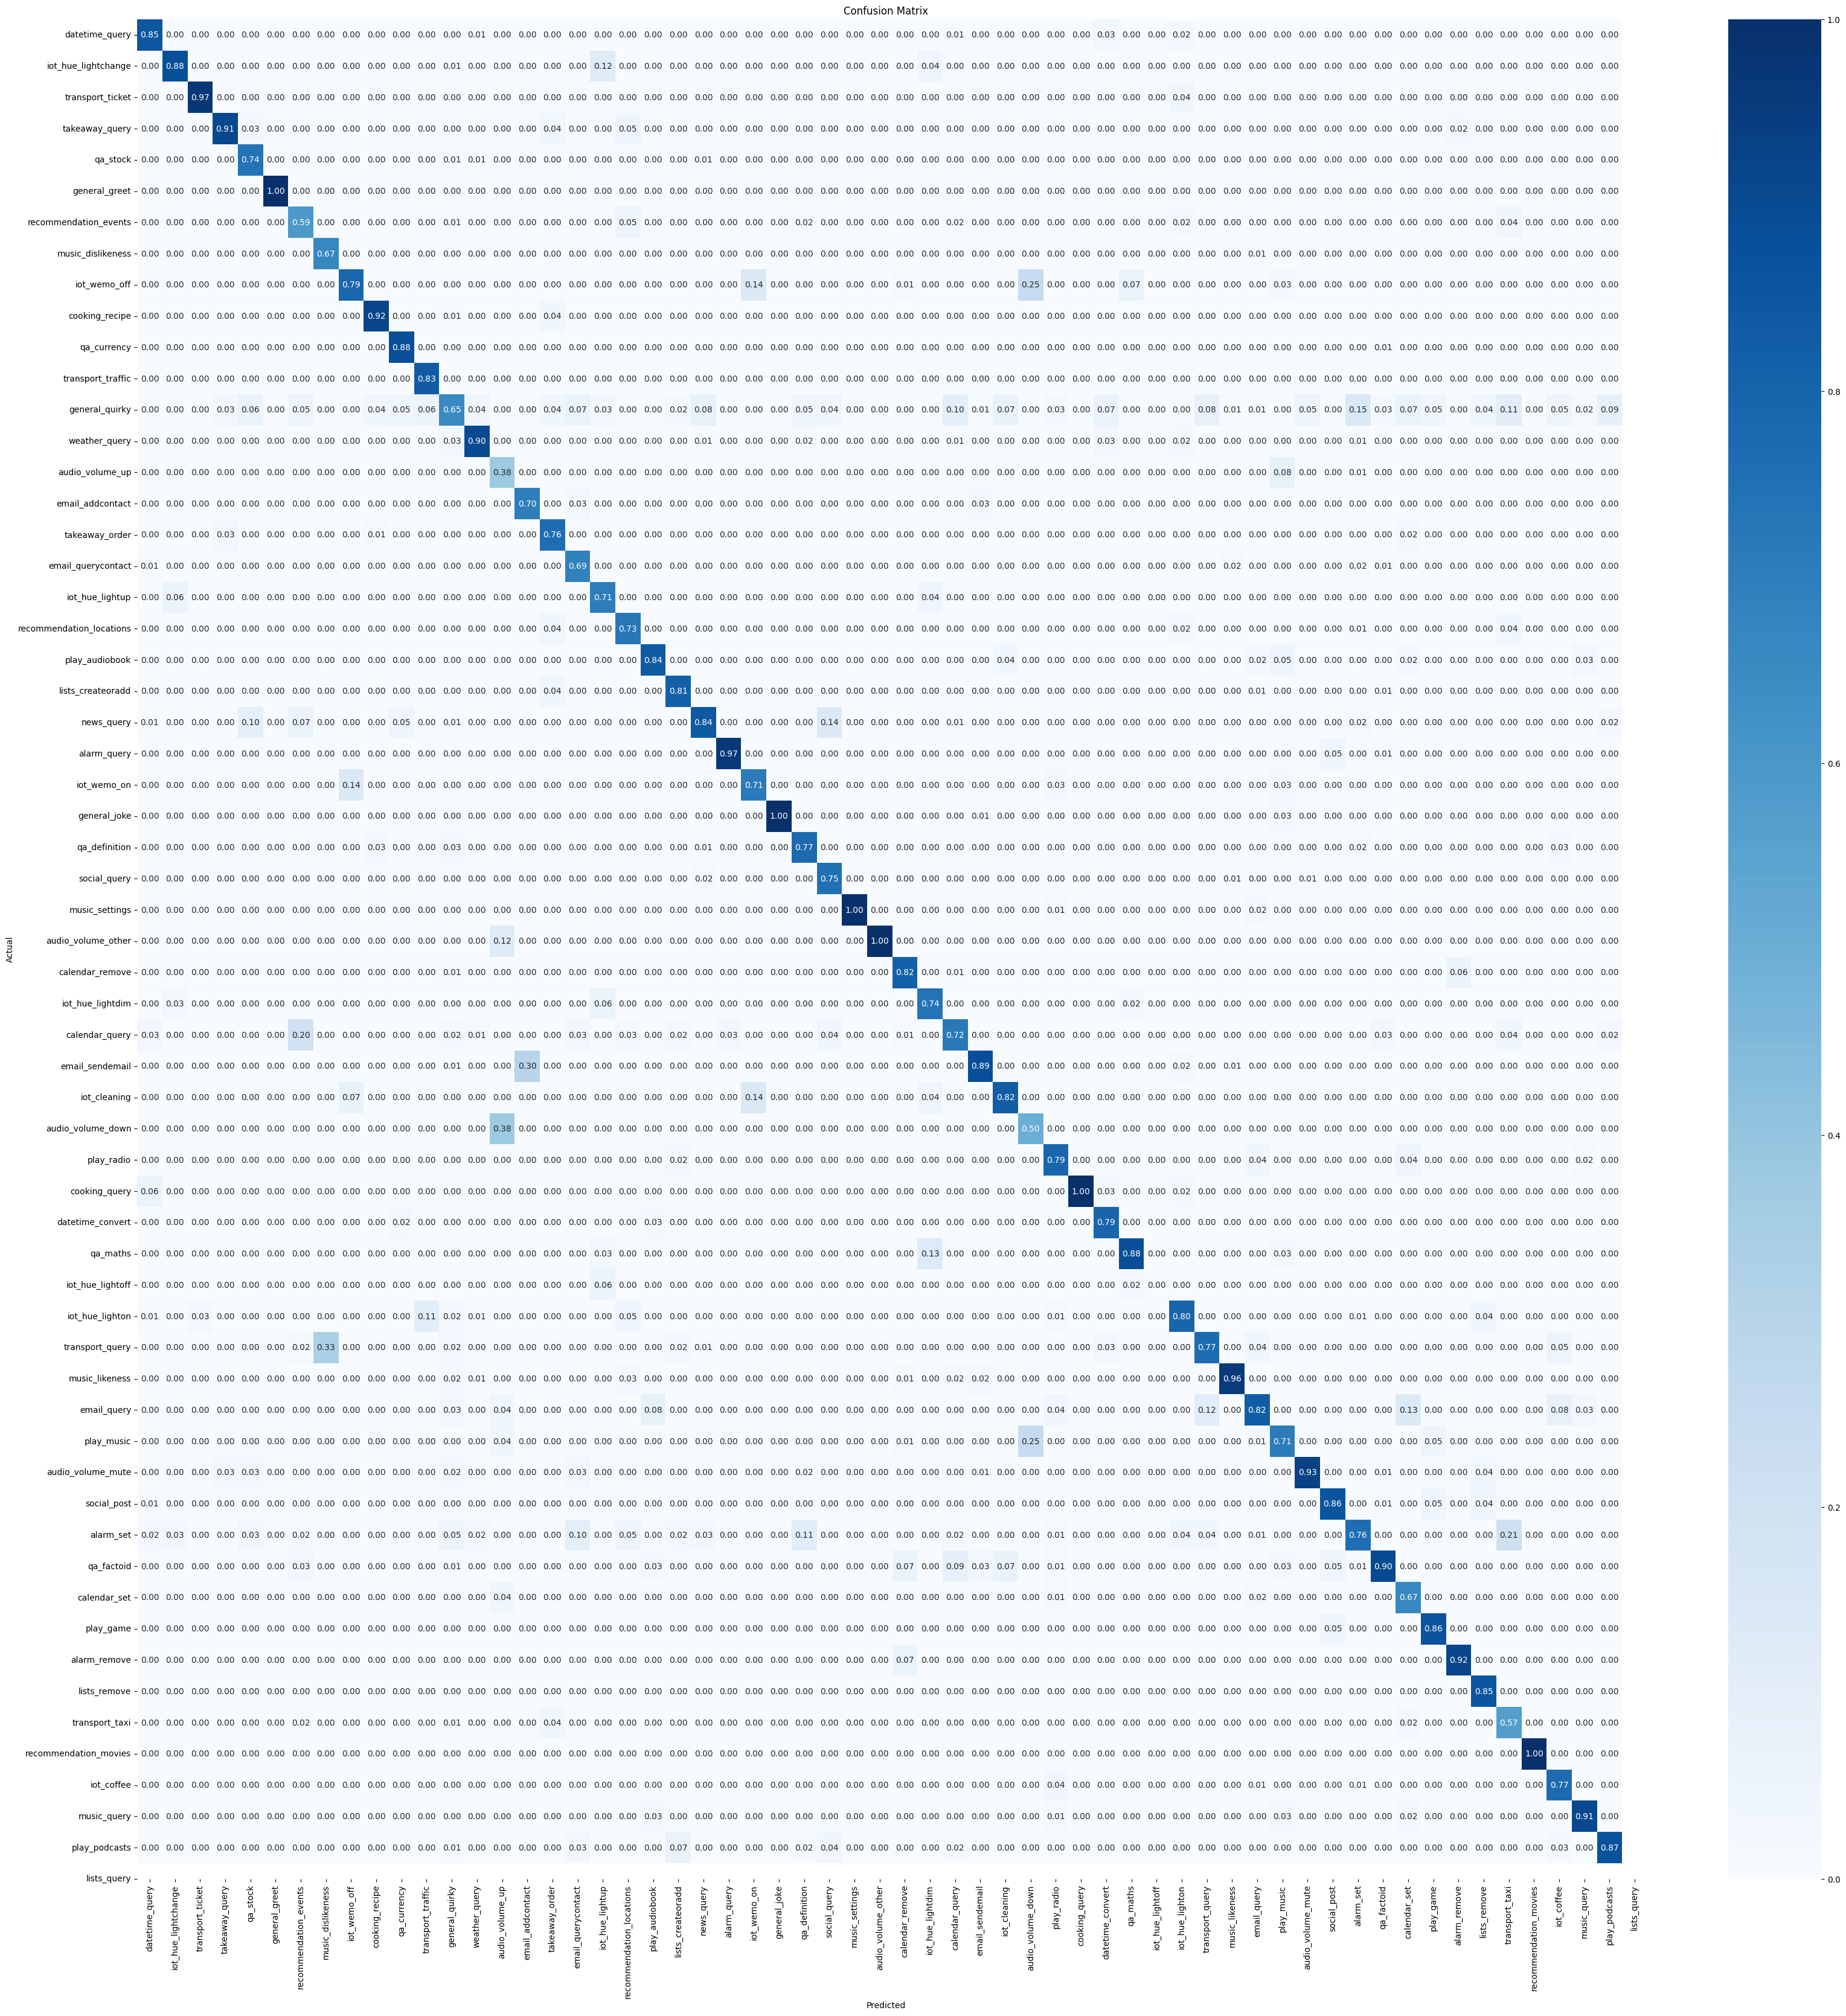

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Calculate the confusion matrix
confusion = confusion_matrix(labels, prediction, normalize="pred")

# Create a heatmap of the confusion matrix
plt.figure(figsize=(40, 40))
sns.heatmap(confusion, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[id2int[x] for x in range(60)], 
            yticklabels=[id2int[x] for x in range(60)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [53]:
conf = torch.tensor(confusion)
conf = conf.argsort(dim=1, descending=True)

In [54]:
confusion

array([[0.84848485, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.88235294, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.96969697, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.76923077, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.90769231,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02564103, 0.        ,
        0.87234043]])

In [55]:
conf

tensor([[ 0, 38, 41,  ..., 26, 27, 28],
        [ 1, 18, 31,  ..., 27, 28, 29],
        [ 2, 41, 45,  ..., 27, 28,  0],
        ...,
        [56, 36, 48,  ..., 26, 27, 28],
        [57, 20, 45,  ..., 27, 28,  0],
        [58, 21, 27,  ..., 28,  0, 30]])

In [56]:
confusion.shape

(59, 59)

In [57]:
import pickle

# Define the file name for saving the confusion matrix as a pickle
file_name = "confusion_matrix_mass.pkl"

# Open the file in binary write mode
with open(file_name, "wb") as file:
    pickle.dump(confusion, file)

print("Confusion Matrix saved as 'confusion_matrix_mass.pkl'")

Confusion Matrix saved as 'confusion_matrix_mass.pkl'


In [58]:
import pickle

# Load the confusion matrix from the pickle file
with open("confusion_matrix.pkl", "rb") as file:
    loaded_confusion = pickle.load(file)

In [59]:
lk = 0
jk = [[] for x in range(60)]
for k, psd in enumerate(list(labels)):
    jk[psd].append(k)

In [60]:
prev = 0
out = []
for j in list(jk):
    sms = softmax_tensor[j, :].mean(dim=0)
    out.append(list(sms))

In [61]:
out = torch.tensor(out)

In [62]:
confidence = out.argsort(dim=1, descending=True).tolist()

In [63]:
file_name = "confidence_matrix_mass.pkl"

# Open the file in binary write mode
with open(file_name, "wb") as file:
    pickle.dump(confidence, file)

print("Confidence Matrix saved as 'confidence_matrix.pkl'")

Confidence Matrix saved as 'confidence_matrix.pkl'


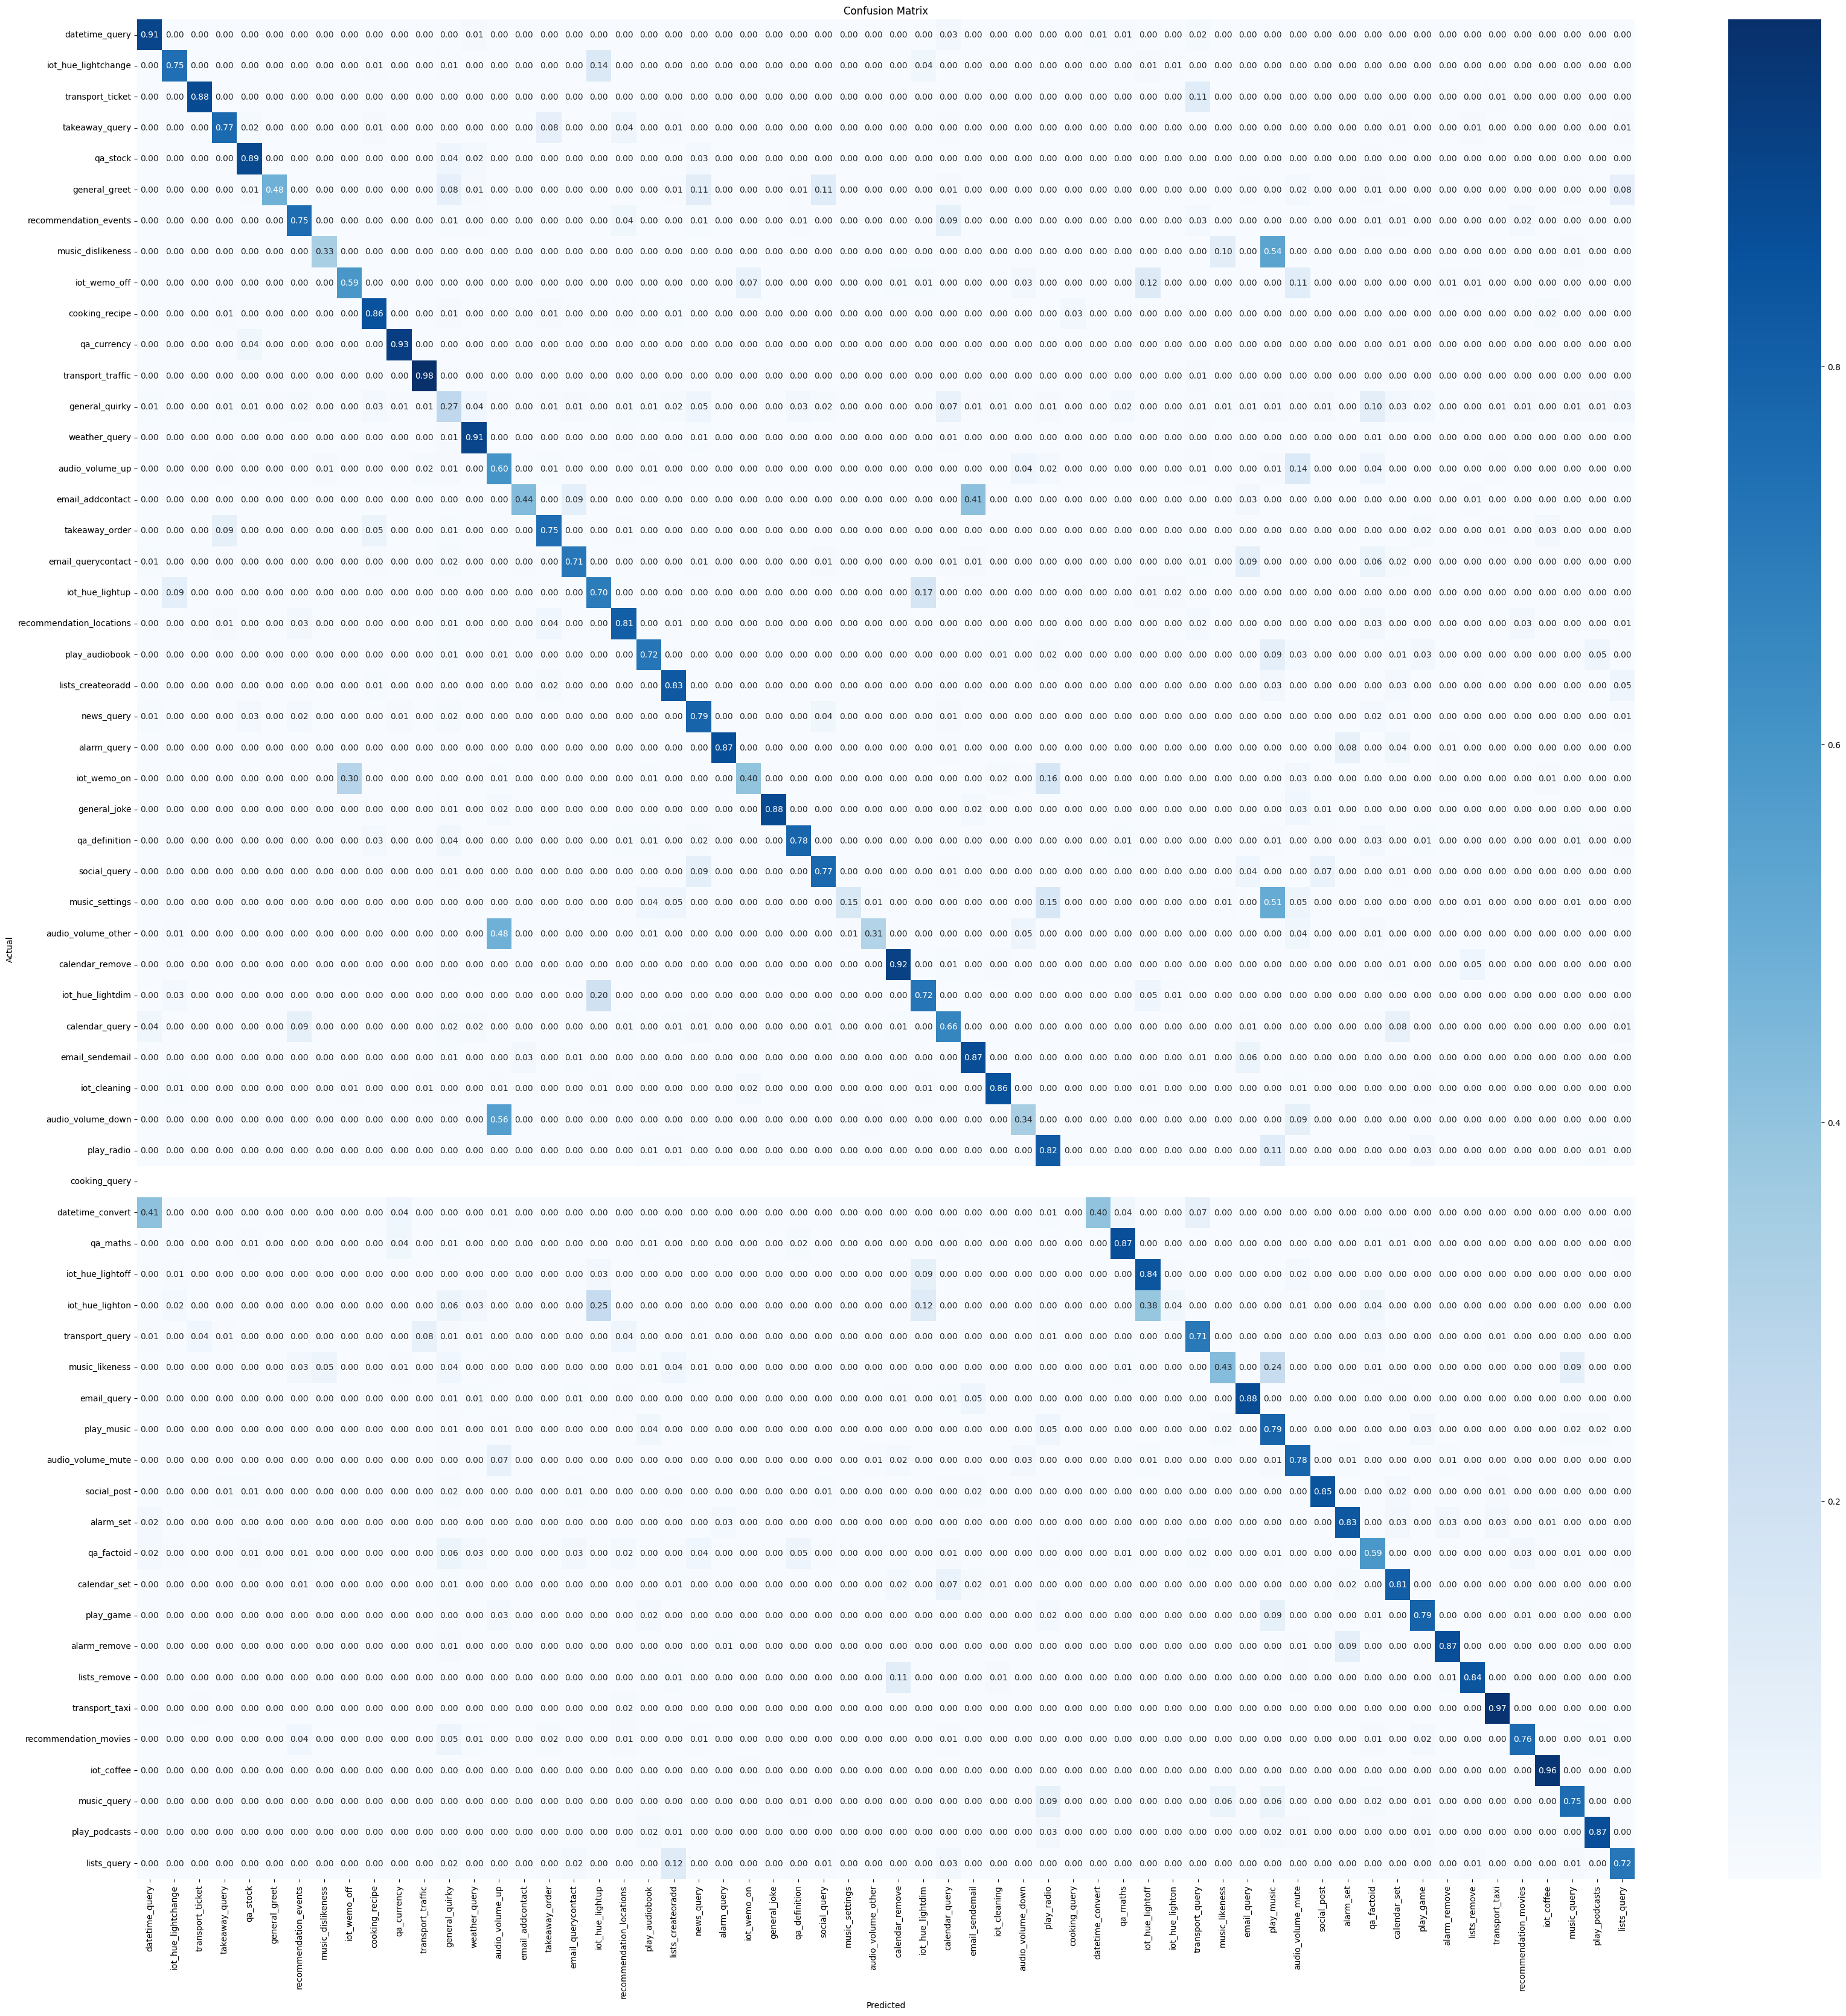

In [65]:
plt.figure(figsize=(40, 40))
sns.heatmap(out, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[id2int[x] for x in range(60)], 
            yticklabels=[id2int[x] for x in range(60)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [65]:
cnfid = {}
for i, esd in enumerate(confidence):
    cnfid[i] = [id2int[x] for x in esd]

In [66]:
for i in range(20):
    print(f"{id2int[i]}: {cnfid[i][1:11]}")

datetime_query: ['datetime_convert', 'qa_maths', 'calendar_query', 'weather_query', 'calendar_set', 'news_query', 'qa_factoid', 'alarm_set', 'transport_query', 'general_quirky']
iot_hue_lightchange: ['iot_hue_lightup', 'iot_hue_lightdim', 'weather_query', 'iot_hue_lighton', 'qa_maths', 'iot_hue_lightoff', 'general_quirky', 'qa_factoid', 'general_greet', 'recommendation_movies']
transport_ticket: ['transport_query', 'transport_taxi', 'general_quirky', 'qa_factoid', 'play_audiobook', 'general_greet', 'news_query', 'play_radio', 'recommendation_events', 'recommendation_locations']
takeaway_query: ['takeaway_order', 'recommendation_locations', 'qa_factoid', 'calendar_query', 'qa_definition', 'general_quirky', 'lists_remove', 'email_querycontact', 'cooking_query', 'cooking_recipe']
qa_stock: ['news_query', 'general_greet', 'qa_factoid', 'qa_currency', 'general_quirky', 'email_querycontact', 'qa_maths', 'calendar_query', 'transport_query', 'qa_definition']
general_greet: ['cooking_query', 'c

In [66]:
cnfu = {}
for i, esd in enumerate(conf):
    cnfu[i] = [id2int[int(x)] for x in esd]

In [67]:
for i in range(20):
    print(f"{id2int[i]}: {cnfu[i][1:11]}")

datetime_query: ['datetime_convert', 'iot_hue_lighton', 'calendar_query', 'weather_query', 'play_music', 'iot_hue_lightdim', 'email_sendemail', 'iot_cleaning', 'audio_volume_down', 'play_radio']
iot_hue_lightchange: ['iot_hue_lightup', 'iot_hue_lightdim', 'general_quirky', 'email_query', 'play_podcasts', 'calendar_query', 'email_sendemail', 'iot_cleaning', 'audio_volume_down', 'play_radio']
transport_ticket: ['iot_hue_lighton', 'play_music', 'iot_hue_lightdim', 'calendar_query', 'email_sendemail', 'iot_cleaning', 'audio_volume_down', 'play_radio', 'cooking_query', 'datetime_convert']
takeaway_query: ['recommendation_locations', 'takeaway_order', 'qa_stock', 'alarm_remove', 'iot_cleaning', 'audio_volume_down', 'play_radio', 'cooking_query', 'calendar_query', 'datetime_convert']
qa_stock: ['general_quirky', 'news_query', 'weather_query', 'qa_maths', 'email_query', 'music_likeness', 'transport_query', 'iot_hue_lighton', 'iot_hue_lightoff', 'audio_volume_mute']
general_greet: ['play_music'

In [21]:
dct = {"id": [], "intent": []}
for i, j in enumerate(list(prediction)):
    dct["id"].append(i)
    dct["intent"].append(j)


In [22]:
def dict_to_dataset(dict):
    dataset = datasets.Dataset.from_dict(dict)
    return dataset

pred = dict_to_dataset(dct)
pred.save_to_disk(f"pred_xlmr")

Saving the dataset (0/1 shards):   0%|          | 0/2239 [00:00<?, ? examples/s]

In [23]:
acc_lst = labels == prediction

In [24]:
print(f"Accuracy = {acc_lst.sum()/2239}")

Accuracy = 0.8311746120452881


In [43]:
labels.view(-1, 1) in torch.argsort(scores, dim=1)[:, :10]

True

In [46]:
prediction

tensor([101, 109,   3,  ...,  47,   6,   3])